In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
path_to_src = os.path.join('../', 'src')
sys.path.insert(0, path_to_src)
from functions import *
%matplotlib inline

Using TensorFlow backend.


In [3]:
def visualize_training_results(history, iteration):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['recall_{}'.format(iteration)])
    ax1.plot(history.history['val_recall_{}'.format(iteration)])
    ax1.set_ylabel('Recall')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    ax3.plot(history.history['precision_{}'.format(iteration)])
    ax3.plot(history.history['val_precision_{}'.format(iteration)])
    ax3.set_ylabel('Precision')
    ax3.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()
    

In [4]:
data_dir_train = '../data/train/'
data_dir_test = '../data/test/'
categories = ['NORMAL', 'PNEUMONIA']

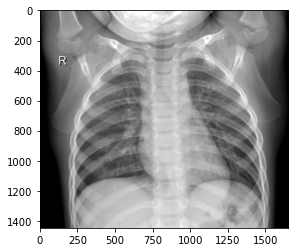

In [5]:
for category in categories:
    path_train = os.path.join(data_dir_train,category)
    for img in os.listdir(path_train):
        img_array_train = cv2.imread(os.path.join(path_train,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_train, cmap="gray")
        plt.show()
        break
    break

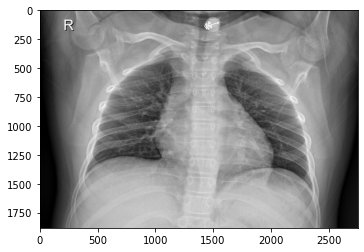

In [6]:
for category in categories:
    path_test = os.path.join(data_dir_test,category)
    for img in os.listdir(path_test):
        img_array_test = cv2.imread(os.path.join(path_test,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_test, cmap="gray")
        plt.show()
        break
    break

In [7]:
print(img_array_train.shape)
print(img_array_test.shape)

(1446, 1654)
(1882, 2752)


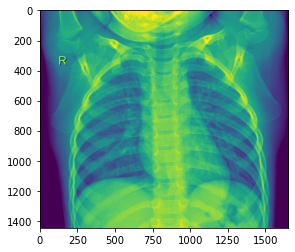

In [8]:
plt.imshow(img_array_train)
plt.show()

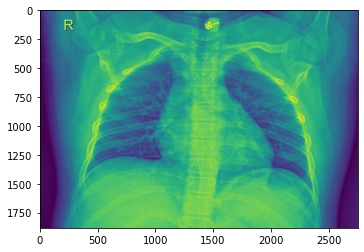

In [9]:
plt.imshow(img_array_test)
plt.show()

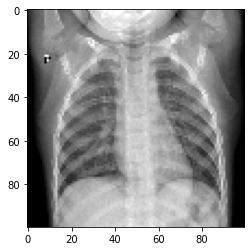

In [10]:
img_size = 100
train_array = cv2.resize(img_array_train,(img_size, img_size))
plt.imshow(train_array, cmap = 'gray')
plt.show()

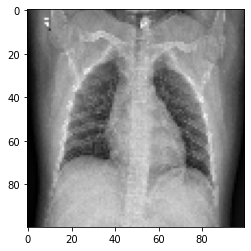

In [11]:
test_array = cv2.resize(img_array_test, (img_size, img_size))
plt.imshow(test_array, cmap = 'gray')
plt.show()

In [12]:
train_data = []
test_data = []

In [13]:
def create_training_data():
    for category in categories:
        path_train = os.path.join(data_dir_train,category)
        class_num = categories.index(category)
        for img in os.listdir(path_train):
            try:
                img_array_train = cv2.imread(os.path.join(path_train,img), cv2.IMREAD_GRAYSCALE)
                train_array = cv2.resize(img_array_train,(img_size, img_size))
                train_data.append([train_array, class_num])
            except Exception as e:
                pass
            
            
def create_testing_data():
    for category in categories:
        path_test = os.path.join(data_dir_test,category)
        class_num = categories.index(category)
        for img in os.listdir(path_test):
            try:
                img_array_test = cv2.imread(os.path.join(path_test,img), cv2.IMREAD_GRAYSCALE)
                test_array = cv2.resize(img_array_test,(img_size, img_size))
                test_data.append([test_array, class_num])
            except Exception as e:
                pass

In [14]:
create_training_data()

In [15]:
create_testing_data()

In [16]:
print('Training data count: {}'.format(len(train_data)))
print('Testing data count: {}'.format(len(test_data)))

Training data count: 5232
Testing data count: 624


In [17]:
for sample in train_data[:5]:
    print('Train', sample[1])
    
for sample in test_data[:5]:
    print('Testing', sample[1])

Train 0
Train 0
Train 0
Train 0
Train 0
Testing 0
Testing 0
Testing 0
Testing 0
Testing 0


In [18]:
X = []
y = []

In [19]:
Xtest = []
ytest = []

In [20]:
for features, label in train_data:
    X.append(features)
    y.append(label)

In [21]:
for features, label in test_data:
    Xtest.append(features)
    ytest.append(label)

In [22]:
X = np.array(X).reshape(-1, img_size, img_size, 1)

In [23]:
X = X/255.0

In [24]:
X.shape

(5232, 100, 100, 1)

In [25]:
Xtest = np.array(Xtest).reshape(-1, img_size, img_size, 1)

In [26]:
Xtest = Xtest/255.0

In [27]:
Xtest.shape

(624, 100, 100, 1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [29]:
X_train.shape

(3924, 100, 100, 1)

In [30]:
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [31]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [32]:
ytest = keras.utils.to_categorical(ytest, num_classes)

In [33]:
ytest = np.array(ytest)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3924, 100, 100, 1)
(3924, 2)
(1308, 100, 100, 1)
(1308, 2)


In [35]:
print(ytest.shape)

(624, 2)


In [36]:
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (3924, 100, 100, 1)
3924 train samples
1308 test samples


# First Model #

In [37]:
base_line = Sequential()
base_line.add(Conv2D(32, kernel_size= 5, activation='relu', padding='same', input_shape=(100, 100, 1)))
base_line.add(MaxPooling2D(2,2))
base_line.add(Flatten())
base_line.add(Dense(16, activation='relu'))
base_line.add(Dense(2, activation='sigmoid'))

In [38]:
base_line.compile(loss="binary_crossentropy", optimizer="adam", metrics = [Precision(), Recall()])


In [39]:
base_line.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1280016   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 1,280,882
Trainable params: 1,280,882
Non-trainable params: 0
_________________________________________________________________


In [40]:
start = time.time()
history_baseline = base_line.fit(X_train,
                      y_train,
                      batch_size = 32,
                      epochs = 5,
                      validation_data= (X_test,y_test))
end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 3924 samples, validate on 1308 samples
Epoch 1/5
3924/3924 [==============================] - 18s 5ms/step - loss: 0.3910 - precision_1: 0.7677 - recall_1: 0.8759 - val_loss: 0.2548 - val_precision_1: 0.7708 - val_recall_1: 0.9434
Epoch 2/5
3924/3924 [==============================] - 18s 5ms/step - loss: 0.1965 - precision_1: 0.8386 - recall_1: 0.9623 - val_loss: 0.1324 - val_precision_1: 0.9571 - val_recall_1: 0.9557
Epoch 3/5
3924/3924 [==============================] - 18s 5ms/step - loss: 0.1094 - precision_1: 0.9565 - recall_1: 0.9580 - val_loss: 0.1028 - val_precision_1: 0.9622 - val_recall_1: 0.9725
Epoch 4/5
3924/3924 [==============================] - 19s 5ms/step - loss: 0.0814 - precision_1: 0.9705 - recall_1: 0.9730 - val_loss: 0.0888 - val_precision_1: 0.9722 - val_recall_1: 0.9618
Epoch 5/5
3924/3924 [==============================] - 19s 5ms/step - loss: 0.0660 - precision_1: 0.9763 - recall_1: 0.9763 - val_loss: 0.0843 - val_precision_1: 0.9781 - val_recall_1:

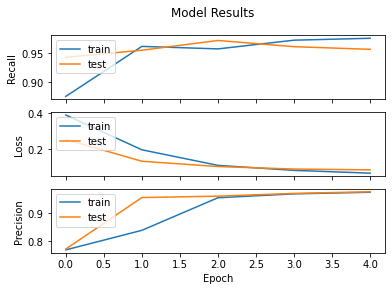

In [42]:
visualize_training_results(history_baseline,1)

In [43]:
results_train = base_line.evaluate(X_train, y_train)
results_test = base_line.evaluate(X_test, y_test)

1308/1308 [==============================] - 1s 560us/step


In [44]:
print(results_train)
print(results_test)

[0.05316428114849007, 0.9873678684234619, 0.9760448336601257]
[0.08428647624334429, 0.9781249761581421, 0.9571865200996399]


In [45]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_2.add(MaxPooling2D(4,4))
model_2.add(Flatten())
model_2.add(Dense(64, activation = 'relu'))
model_2.add(Dense(2, activation = 'sigmoid'))

In [46]:
model_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [47]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 100, 64)      1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2560064   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 2,561,858
Trainable params: 2,561,858
Non-trainable params: 0
_________________________________________________________________


In [48]:
start = time.time()
history_model_2 = model_2.fit(X_train,
                              y_train,
                              batch_size = 32,
                              epochs = 5,
                              validation_data = (X_test,y_test))
end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 3924 samples, validate on 1308 samples
Epoch 1/5
3924/3924 [==============================] - 30s 8ms/step - loss: 0.2976 - precision_2: 0.8880 - recall_2: 0.8611 - val_loss: 0.1276 - val_precision_2: 0.9393 - val_recall_2: 0.9702
Epoch 2/5
3924/3924 [==============================] - 30s 8ms/step - loss: 0.1174 - precision_2: 0.9582 - recall_2: 0.9587 - val_loss: 0.1379 - val_precision_2: 0.9435 - val_recall_2: 0.9442
Epoch 3/5
3924/3924 [==============================] - 31s 8ms/step - loss: 0.0950 - precision_2: 0.9670 - recall_2: 0.9648 - val_loss: 0.0891 - val_precision_2: 0.9652 - val_recall_2: 0.9740
Epoch 4/5
3924/3924 [==============================] - 31s 8ms/step - loss: 0.0801 - precision_2: 0.9709 - recall_2: 0.9681 - val_loss: 0.0744 - val_precision_2: 0.9777 - val_recall_2: 0.9717
Epoch 5/5
3924/3924 [==============================] - 31s 8ms/step - loss: 0.0655 - precision_2: 0.9766 - recall_2: 0.9766 - val_loss: 0.0722 - val_precision_2: 0.9733 - val_recall_2:

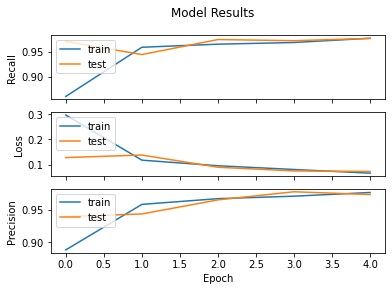

In [49]:
visualize_training_results(history_model_2, 2)

In [50]:
model_3 = Sequential()
model_3.add(Conv2D(128, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_3.add(Dense(64, activation = 'tanh'))
model_3.add(MaxPooling2D(4,4))
model_3.add(Flatten())
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dense(16, activation = 'sigmoid'))
model_3.add(Dense(2, activation = 'sigmoid'))

In [51]:
model_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [52]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 128)     3328      
_________________________________________________________________
dense_5 (Dense)              (None, 100, 100, 64)      8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1280032   
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

In [53]:
start = time.time()
history_model_3 = model_3.fit(X_train,
                              y_train,
                              batch_size= 32,
                              epochs = 10,
                             validation_data = (X_test, y_test))

end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 3924 samples, validate on 1308 samples
Epoch 1/10
3924/3924 [==============================] - 80s 20ms/step - loss: 0.5551 - precision_3: 0.7492 - recall_3: 0.7413 - val_loss: 0.5476 - val_precision_3: 0.7217 - val_recall_3: 0.7217
Epoch 2/10
3924/3924 [==============================] - 79s 20ms/step - loss: 0.4581 - precision_3: 0.7490 - recall_3: 0.7490 - val_loss: 0.4181 - val_precision_3: 0.7217 - val_recall_3: 0.7217
Epoch 3/10
3924/3924 [==============================] - 79s 20ms/step - loss: 0.3507 - precision_3: 0.8375 - recall_3: 0.7895 - val_loss: 0.2988 - val_precision_3: 0.9644 - val_recall_3: 0.9534
Epoch 4/10
3924/3924 [==============================] - 80s 20ms/step - loss: 0.2325 - precision_3: 0.9532 - recall_3: 0.9495 - val_loss: 0.1864 - val_precision_3: 0.9528 - val_recall_3: 0.9564
Epoch 5/10
3924/3924 [==============================] - 81s 21ms/step - loss: 0.1578 - precision_3: 0.9608 - recall_3: 0.9630 - val_loss: 0.1909 - val_precision_3: 0.9300 - val

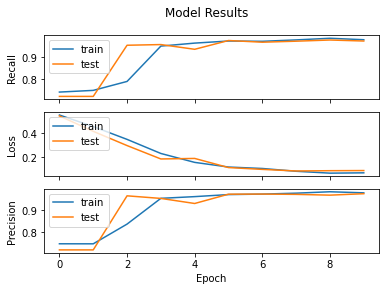

In [54]:
visualize_training_results(history_model_3, 3)

In [55]:
model_4 = Sequential()
model_4.add(Conv2D(128, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_4.add(Dense(64, activation = 'tanh'))
model_4.add(MaxPooling2D(4,4))
model_4.add(Flatten())
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dense(16, activation = 'sigmoid'))
model_4.add(Dense(8, activation = 'tanh'))
model_4.add(Dense(2, activation = 'sigmoid'))

In [56]:
model_4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [57]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 128)     3328      
_________________________________________________________________
dense_9 (Dense)              (None, 100, 100, 64)      8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1280032   
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                

In [58]:
start = time.time()
history_model_4 = model_4.fit(X_train,
                              y_train,
                              batch_size = 64,
                              epochs = 15,
                              validation_data = (X_test, y_test))
end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 3924 samples, validate on 1308 samples
Epoch 1/15
3924/3924 [==============================] - 76s 19ms/step - loss: 0.5509 - precision_4: 0.7490 - recall_4: 0.7490 - val_loss: 0.5367 - val_precision_4: 0.7217 - val_recall_4: 0.7217
Epoch 2/15
3924/3924 [==============================] - 73s 19ms/step - loss: 0.4765 - precision_4: 0.7490 - recall_4: 0.7490 - val_loss: 0.4481 - val_precision_4: 0.7217 - val_recall_4: 0.7217
Epoch 3/15
3924/3924 [==============================] - 74s 19ms/step - loss: 0.3997 - precision_4: 0.7742 - recall_4: 0.7472 - val_loss: 0.3530 - val_precision_4: 0.9263 - val_recall_4: 0.8173
Epoch 4/15
3924/3924 [==============================] - 74s 19ms/step - loss: 0.2596 - precision_4: 0.9564 - recall_4: 0.9271 - val_loss: 0.1975 - val_precision_4: 0.9598 - val_recall_4: 0.9495
Epoch 5/15
3924/3924 [==============================] - 73s 19ms/step - loss: 0.1560 - precision_4: 0.9650 - recall_4: 0.9618 - val_loss: 0.1278 - val_precision_4: 0.9706 - val

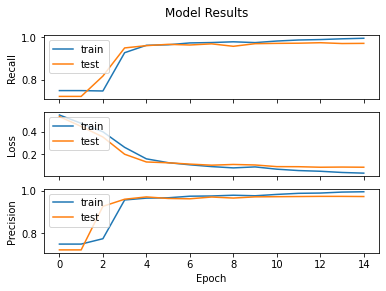

In [59]:
visualize_training_results(history_model_4, 4)

In [ ]:
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
print('Notebook run using keras:', keras.__version__)

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [ ]:
preds = model_4.predict(X_train)
for x in decode_predictions(preds)[0]:
    print(x)